## Import dependencies

In [1]:
# Standard Library Imports
import os
import sys
from subprocess import call
import json
import time
import traceback
import asyncio
import aiohttp
import re

# Third-Party Library Imports
import numpy as np
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import webdataset as wds
import nibabel as nib
import pickle as pkl
from einops import rearrange
import torchvision.transforms as transforms
from PIL import Image
import torch
import torchio as tio
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler

/admin/home-paulscotti/found/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/admin/home-paulscotti/found/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Helper functions

In [2]:
def reshape_to_2d(tensor):
    return rearrange(tensor, 'b h w c -> (b h) (c w)')

def reshape_to_original(tensor_2d, b=300, h=64, w=64, c=48):
    return rearrange(tensor_2d, '(b h) (c w) -> b h w c', b=b, h=h, w=w, c=c)

def header_to_dict(header):
    readable_header = {}
    for key, value in header.items():
        readable_header[key] = value
    return readable_header

def temporal_interp1d(fmri_data, change_TR):
    original_time_points = np.arange(fmri_data.shape[0])  # Time points: 0, 1, 2, ..., T-1
    new_time_points = np.arange(0, fmri_data.shape[0], change_TR)  # New time points: 0, 2, 4, ...

    reshaped_data = fmri_data.reshape(fmri_data.shape[0], -1)  # Reshape to (T, X*Y*Z)
    interpolate = interp1d(original_time_points, reshaped_data, kind='linear', axis=0, bounds_error=False, fill_value="extrapolate")
    resampled_fmri_data = interpolate(new_time_points).reshape((len(new_time_points),) + fmri_data.shape[1:])
    return resampled_fmri_data

def torchio_slice(data,xslice=None,yslice=None,zslice=None):    
    if xslice is None: xslice = data.shape[1] // 2
    if yslice is None: yslice = data.shape[2] // 2
    if zslice is None: zslice = data.shape[3] // 2

    fig, axs = plt.subplots(1, 3, figsize=(5,5))

    # Plot the three different slices
    axs[0].imshow(data[0, xslice], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f'Slice [0, {xslice}]', fontsize=8)

    axs[1].imshow(data[0, :, yslice], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f'Slice [0, :, {yslice}]', fontsize=8)

    axs[2].imshow(data[0, :, :, zslice], cmap='gray')
    axs[2].axis('off')
    axs[2].set_title(f'Slice [0, :, :, {zslice}]', fontsize=8)
    
    plt.show()
    
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

## Create dir to save dataset

In [3]:
temp_folder = os.getcwd()+'/temp_MNIs'
os.makedirs(temp_folder, exist_ok=True)
print(temp_folder)

# wds_folder = os.getcwd()+'/wds'
wds_folder = os.getcwd()+'/wds/nsd'
os.makedirs(wds_folder, exist_ok=True)
print(wds_folder)

/weka/proj-fmri/paulscotti/fMRI-foundation-model/dataset_creation/wds_creation/temp_MNIs
/weka/proj-fmri/paulscotti/fMRI-foundation-model/dataset_creation/wds_creation/wds/nsd


In [4]:
# delete saved files
command = f"rm {temp_folder}/*"
call(command,shell=True)

# delete saved files
command = f"rm {wds_folder}/*"
call(command,shell=True)

rm: cannot remove '/weka/proj-fmri/paulscotti/fMRI-foundation-model/dataset_creation/wds_creation/temp_MNIs/*': No such file or directory
rm: cannot remove '/weka/proj-fmri/paulscotti/fMRI-foundation-model/dataset_creation/wds_creation/wds/nsd/*': No such file or directory


1

## Job

In [5]:
s3 = boto3.client('s3')
bucket_name = 'proj-fmri'
# prefix = 'fmri_foundation_datasets/openneuro_MNI/'
prefix = 'fmri_foundation_datasets/NSD_MNI/'

paginator = s3.get_paginator('list_objects_v2')
file_name_list = []
for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
    for obj in page.get('Contents', []):
        file_name = obj['Key']
        file_name_list.append(file_name)
print("len(file_name_list) =", len(file_name_list))

len(file_name_list) = 4


In [6]:
from collections import defaultdict

# Initialize a dictionary to hold the categorized file paths
datasets = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for file_name in file_name_list:
    parts = file_name.split('/')
    dataset_id = parts[2]
    subject_parts = parts[3].split('_')
    subject_id = subject_parts[0]  # Extract the subject identifier

    # Check for session identifier, default to "ses-01" if not present
    session_id = "ses-01"
    for part in subject_parts:
        if part.startswith("ses-"):
            session_id = part
            break
    
    datasets[dataset_id][subject_id][session_id].append(file_name)

Starting from scratch!
TR_count: 0
subj_count: 0
tar_count: 0
dataset_count: 0
Processing ses-nsd01 sub-01 ses-nsd01 | TR_count 0
download: s3://proj-fmri/fmri_foundation_datasets/NSD_MNI/ses-nsd01/sub-01_ses-nsd01_task-nsdcore_run-01_bold_MNI.nii.gz to temp_MNIs/ses-nsd01_sub-01_ses-nsd01_task-nsdcore_run-01_bold_MNI.nii.gz
download: s3://proj-fmri/fmri_foundation_datasets/NSD_MNI/ses-nsd01/sub-01_ses-nsd01_task-nsdcore_run-02_bold_MNI.nii.gz to temp_MNIs/ses-nsd01_sub-01_ses-nsd01_task-nsdcore_run-02_bold_MNI.nii.gz
download: s3://proj-fmri/fmri_foundation_datasets/NSD_MNI/ses-nsd01/sub-01_ses-nsd01_task-nsdcore_run-03_bold_MNI.nii.gz to temp_MNIs/ses-nsd01_sub-01_ses-nsd01_task-nsdcore_run-03_bold_MNI.nii.gz
download: s3://proj-fmri/fmri_foundation_datasets/NSD_MNI/ses-nsd01/sub-01_ses-nsd01_task-nsdcore_run-04_bold_MNI.nii.gz to temp_MNIs/ses-nsd01_sub-01_ses-nsd01_task-nsdcore_run-04_bold_MNI.nii.gz
min = 0.0 | max = 1083.75


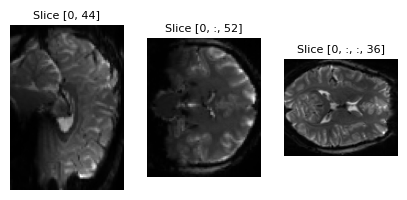

None

last batch | len(out) = 32
last batch | len(out) = 32
last batch | len(out) = 32
last batch | len(out) = 32
TR_count 768


/bin/sh: 1: cannot open module: No such file
rm: cannot remove '/weka/proj-fmri/paulscotti/fMRI-foundation-model/dataset_creation/wds_creation/temp_MNIs/*': No such file or directory
/bin/sh: 1: cannot open module: No such file


2

In [12]:
print("Starting from scratch!")

try:
    sink.close()
except:
    pass
    
tar_count = 0
TR_count = 0
subj_count = 0
dataset_count = 0
dataset_list = []

print(f"TR_count: {TR_count}")
print(f"subj_count: {subj_count}")
print(f"tar_count: {tar_count}")
print(f"dataset_count: {dataset_count}")

TRs_per_sample = 32
max_samples_per_tar = 30 # try to translate to around 1 Gb per tar
max_TRs_per_tar = max_samples_per_tar * TRs_per_sample

sample_idx = 0
current_dataset = None
current_subject = None

MNI_mask = nib.load("/weka/proj-fmri/paulscotti/fMRI-foundation-model/dataset_creation/afni_conversion/tpl-MNI152NLin2009cAsym_res-02_T1w_brain.nii.gz").get_fdata()
MNI_mask[MNI_mask>0]=1
MNI_mask = MNI_mask.astype(bool)

sink = wds.TarWriter(f"{wds_folder}/{tar_count:06d}.tar")

for dataset_id in list(datasets.keys()):
    # first get min and max across all target subjects data
    first = True
    for subject_id in list(datasets[dataset_id].keys()):
        for session_id in list(datasets[dataset_id][subject_id].keys()):
            print(f"Processing {dataset_id} {subject_id} {session_id} | TR_count {TR_count}")
            
            # first get min and max values across all runs in session
            run_count = 0
            for file_name in datasets[dataset_id][subject_id][session_id]:
                temp_file_path = temp_folder + '/' + file_name.split('/')[2] + '_' + file_name.split('/')[-1]
            
                if not os.path.exists(temp_file_path):
                    # s3.download_file(bucket_name, file_name, temp_file_path)
                    command = f"aws s3 cp s3://proj-fmri/{file_name} {temp_file_path}"
                    call(command,shell=True)

                if not os.path.exists(temp_file_path):
                    raise Exception("s3 file not found")
            
                func_nii = nib.load(temp_file_path).get_fdata()
                func_nii = np.moveaxis(func_nii, -1, 0)
                data = func_nii[:,MNI_mask] # find normalization values only inside of the MNI brain mask

                # ignore outliers via standard deviation exclusion
                low = data.mean() - 2 * data.std()
                high = data.mean() + 2 * data.std()
                filtered_data = data[(data > low) & (data < high)]
                min_val = np.min(filtered_data)
                max_val = np.max(filtered_data)
                
                run_count +=1
                if run_count==1: 
                    min = min_val
                    max = max_val
                else:
                    min += min_val
                    max += max_val
                    
            min /= run_count
            max /= run_count
            print(f"min = {min} | max = {max}")
            
            for file_name in datasets[dataset_id][subject_id][session_id]:
                temp_file_path = temp_folder + '/' + file_name.split('/')[2] + '_' + file_name.split('/')[-1]
    
                func_nii = nib.load(temp_file_path).get_fdata()
                func_nii = np.moveaxis(func_nii, -1, 0)
                func_nii = func_nii[:,6:94,8:112,10:82].astype(np.float16) # [T, 97, 115, 97] to [T, 88, 104, 72]

                if first and is_interactive():
                    display(torchio_slice(func_nii))
                    first = False
    
                # normalize by min max
                func_nii = (func_nii - min) / (max - min)
            
                # create samples of TRs_per_sample TRs
                for batch in range(0,len(func_nii),TRs_per_sample):
                    out = func_nii[batch:batch+TRs_per_sample]
                    if len(out)!=TRs_per_sample:
                        out = func_nii[-TRs_per_sample:]
                        print("last batch | len(out) =",len(out))

                    # further sanity check (maybe it was really short run)
                    if len(out)!=TRs_per_sample:
                        continue
            
                    sink.write({
                        "__key__": "%06d" % sample_idx,
                        "func.npy": out,
                    })
                    # "dataset_id.txt": dataset_id,
                    # "subject_id.txt": subject_id,
                    # "session_id.txt": session_id,
            
                    TR_count += len(out)
                    sample_idx += 1
            
                    if sample_idx >= max_samples_per_tar:
                        print("HIT MAX SAMPLES PER TAR")
                        sink.close()
                        sample_idx = 0
            
                        # make metadata file and save progress to aws s3
                        data = {
                            "TR_count": TR_count,
                        }
                        with open(f"{wds_folder}/metadata.json", "w") as file:
                            json.dump(data, file)
            
                        # # send to aws s3
                        # command = f"aws s3 sync {wds_folder} s3://proj-fmri/fmri_foundation_datasets/openneuro_MNI_wds/"
                        # call(command,shell=True)
            
                        tar_count += 1
                        sink = wds.TarWriter(f"{wds_folder}/{tar_count:06d}.tar")

            # delete saved files
            command = f"rm {temp_folder}/*"
            call(command,shell=True)

            last_tar_count = tar_count - 1
            command = f"rm {wds}/{last_tar_count:06d}.tar"
            call(command,shell=True)

print("TR_count",TR_count)       
try:
    sink.close()
except:
    pass

data = {
    "TR_count": TR_count,         
}

with open(f"{wds_folder}/metadata.json", "w") as file:
    json.dump(data, file)

# # send to aws s3
# command = f"aws s3 sync {wds_folder} s3://proj-fmri/fmri_foundation_datasets/openneuro_MNI_wds/"
# call(command,shell=True)

# delete saved files
command = f"rm {temp_folder}/*"
call(command,shell=True)

command = f"rm {wds}/{tar_count-1:06d}.tar"
call(command,shell=True)